In [1]:
import torch as t

init_model = lambda: t.nn.Sequential(t.nn.Linear(16, 128), t.nn.ReLU(), t.nn.Linear(128, 16))
data = lambda n_batches: [t.randn((32, 16)) for _ in range(n_batches)]

In [ ]:
import torch as t

init_model = lambda: t.nn.Sequential(t.nn.Linear(16, 128), t.nn.ReLU(), t.nn.Linear(128, 16))
data = lambda n_batches: [t.randn((32, 16)) for _ in range(n_batches)]

############### Forward pass ###############

model = init_model()
data_batches = data(n_batches = 2)

stored_outputs = []
for i, inputs in enumerate(data_batches):
    stored_outputs.append(model(inputs))
    
############### Backward pass ##############

loss_fn = t.nn.MSELoss()
optimizer = t.optim.SGD(model.parameters(), 0.1)

for i, targets in enumerate(data_batches):
    optimizer.zero_grad()
    outputs = stored_outputs[i]
    loss = loss_fn(targets, outputs)
    loss.backward()
    optimizer.step()

I think the problem is related to the saved tensors on the graph. The best source of info I've found about this is here:

https://pytorch.org/tutorials/intermediate/autograd_saved_tensors_hooks_tutorial.html

The hacky fix is just to re-run the forward pass each time before running the backward pass to repopulate the saved tensors correctly. There's probably a better fix that involves packing, saving, and unpacking the saved tensors appropriately for each microbatch.

In [ ]:
x = data_batches[0]
outputs = model(x)
loss = loss_fn(x, outputs)

# This is one of the secret stateful tensors that stick around in the computation graph
loss.grad_fn._saved_self[:5]

In [ ]:
# Here's another one
loss.grad_fn.next_functions[1][0]._saved_mat1

---

### Trying to fix the problem with `t.autograd.graph.saved_tensors_hooks`

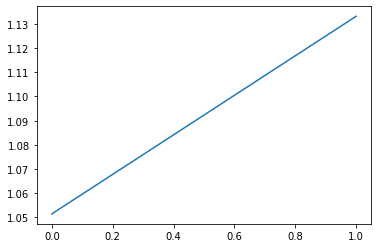

In [29]:
import matplotlib.pyplot as plt

pack_order, unpack_order = {}, {}
storage = []
def pack(x):
    storage.append(x)
    pack_order.append(len(storage) - 1)
    return len(storage) - 1

def unpack(x):
    unpack_order.append(x)
    return storage[x]

############### Forward pass ###############

model = init_model()
model_state = model.state_dict()

model = init_model()
model.load_state_dict(model_state) # Weird that this needs to happen but ok

data_batches = data(n_batches = 2)

stored_outputs = {}
for i, inputs in enumerate(data_batches):
    with t.autograd.graph.saved_tensors_hooks(pack, unpack): # This is the new line
        outputs = model(inputs)
    stored_outputs[i] = outputs

############### Backward pass ##############

loss_fn = t.nn.MSELoss()
optimizer = t.optim.SGD(model.parameters(), 0.1)
losses = []

for i, targets in enumerate(data_batches):
    optimizer.zero_grad()
    outputs = stored_outputs[i]
    with t.autograd.graph.saved_tensors_hooks(pack, unpack):
        loss = loss_fn(targets, outputs)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())

plt.plot(losses); # No error, but it doesn't seem to be training either

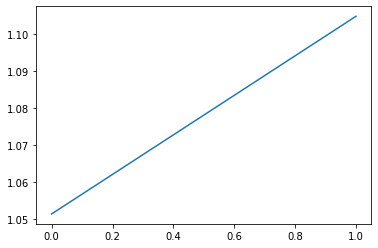

In [30]:
# Let's compare the storage against what it should be

pack_order_2, unpack_order_2 = [], []
storage_2 = []
def pack_2(x):
    storage_2.append(x)
    pack_order_2.append(len(storage_2) - 1)
    return len(storage_2) - 1

def unpack_2(x):
    unpack_order_2.append(x)
    return storage_2[x]

model = init_model()
model.load_state_dict(model_state)

loss_fn = t.nn.MSELoss()
optimizer = t.optim.SGD(model.parameters(), 0.1)
stored_outputs_2= {}
losses= []
for i, inputs in enumerate(data_batches):
    optimizer.zero_grad()
    with t.autograd.graph.saved_tensors_hooks(pack_2, unpack_2):
        outputs = model(inputs)
        loss = loss_fn(outputs, inputs)
    stored_outputs_2[i] = outputs
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
plt.plot(losses);

In [31]:
[o.sum() for i, o in stored_outputs.items()]

[tensor(1.2407, grad_fn=<SumBackward0>),
 tensor(5.9865, grad_fn=<SumBackward0>)]

In [32]:
[o.sum() for i, o in stored_outputs_2.items()]

[tensor(1.2407, grad_fn=<SumBackward0>),
 tensor(7.7783, grad_fn=<SumBackward0>)]

In [35]:
pack_order, pack_order_2

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [36]:
unpack_order, unpack_order_2

([8, 9, 2, 3, 1, 0, 10, 11, 6, 7, 5, 4],
 [4, 5, 2, 3, 1, 0, 10, 11, 8, 9, 7, 6])

In [38]:
[storage[i].shape == (storage_2[i].shape) for i in range(len(storage))]

[True, True, True, True, True, False, False, True, False, False, True, True]

In [39]:
[storage[i].equal(storage_2[i]) for i in range(len(storage))]

[True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [ ]:
storage[0].shape, storage_2[0].shape

Let's try something even simpler

In [ ]:
storage = []
def pack(x):
    storage.append(x)
    return len(storage) - 1

def unpack(x):
    return storage[x]
    return t.tensor(42)

batch, n = 10, 5
X = t.randint(0, 64, (batch, n)).float()
y = t.randn((n,)) * X
w = t.randn((n,), requires_grad=True)

with t.autograd.graph.saved_tensors_hooks(pack, unpack):
    y_pred = w * X
    loss = ((y_pred - y).square()).mean()

loss.grad_fn.next_functions[0][0]._saved_self

In [ ]:
get_saved_tensors(loss.grad_fn)

In [ ]:
import torch as t

def fns_set(grad_fn): # Returns the set of all backwards functions in the graph
    if not hasattr(grad_fn, 'next_functions'): return grad_fn
    return {grad_fn}.union(*(fns_set(fn) for fn, _ in grad_fn.next_functions if fn is not None))

def get_saved_tensors(grad_fn):
    return {
        fn: {attr: getattr(fn, attr) for attr in dir(fn) if attr.startswith('_saved')}
        for fn in fns_set(grad_fn)
    }

batch, n = 10, 5
X = t.randint(0, 64, (batch, n)).float()
y = t.randn((n,)) * X

w = t.randn((n,), requires_grad=True)
y_pred = w * X
loss = ((y_pred - y).square()).mean()

get_saved_tensors(loss.grad_fn)

In [ ]:
batch, n = 3, 5
X = t.randint(0, 64, (batch, n)).float()
y = t.randn((n,)) * X

w = t.randn((n,), requires_grad=True)

storage = []
def pack(x):
    storage.append(x)
    return len(storage) - 1

def unpack(x):
    print('Unpacking %d' % x)
    return storage[x]

with t.autograd.graph.saved_tensors_hooks(pack, unpack):
    y_pred = w * X
    loss = ((y_pred - y).square()).mean()

loss.backward()
    
storage

---

### Trying to understand the computational graph better
- Where are `saved_tensor`s stored? Can I see them in their packed form?
- How do the various `grad_fn`s and `next_functions` correspond with the forwards graph?

In [ ]:
keys = {}
def get_tree(grad_fn):
    
    if grad_fn not in keys:
        keys[grad_fn] = max(keys.values(), default=0) + 1
        
    if not hasattr(grad_fn, 'next_functions'): return keys[grad_fn]
    
    result = {}
    for fn, _ in grad_fn.next_functions:
        if fn is not None:
            result[keys[fn]] = get_tree(fn) 
    return result

def get_tree(grad_fn):
    if not hasattr(grad_fn, 'next_functions'): return grad_fn
    return {fn: get_tree(fn) for fn, _ in grad_fn.next_functions if fn is not None}

tree = get_tree(loss.grad_fn)
print(tree)

In [ ]:
k = list(keys.keys())
k

---

### Sanity check: this training regime should work, right?

In [ ]:
import torch as t
import matplotlib.pyplot as plt

model = t.nn.Sequential(t.nn.Linear(16, 128), t.nn.ReLU(), t.nn.Linear(128, 16))

batch_size, n_batches = 128, 500
data_batches = [t.randn((batch_size, 16)) for _ in range(n_batches)]

loss_fn = t.nn.MSELoss()
optimizer = t.optim.SGD(model.parameters(), 0.1)
losses= []
for i, inputs in enumerate(data_batches):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, inputs)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
plt.plot(losses);